In [86]:
import pyagrum as gum
import pyagrum.lib.notebook as gnb

In [87]:
class ClusterNode:
    id = 1
    def __init__(self, submodelNodes, interfaceVars):
        self.id = ClusterNode.id
        ClusterNode.id += 1
        self.submodelNodes = submodelNodes
        self.parent = None
        self.children = []
        self.interfaceVars = interfaceVars  # RELo
        self.message = []  # messages received
        self.isLeaf = False
        self.computedChildren = 0

    def __str__(self):
        return f'node {self.id}'
    
    def getLeaves(self, res):
        if self.isLeaf:
            res.add(self)
        else:
            for c in self.children:
                c.getLeaves(res)

In [88]:
def ComputeLMEU(Submodel):
    return {0:1}

def ComputeTstMEU(Tst):
    leaves = set()
    Tst.getLeaves(leaves)
    leaves = list(leaves)
    MEU = 0

    while leaves:
        tst = leaves.pop(0)
        Vc = ComputeLMEU(tst) # IS A DICT

        if len(Vc) == 1:
            MEU += list(Vc.values())[0]
        else:
            p = tst.parent
            p.messages.append(Vc)
            p.computedChildren += 1
            if p.computedChildren == len(p.children):
                leaves.append(p)
    return MEU


In [89]:
def RELu(id, D):
    """
    Get the relevant utility functions to decision set D
    """
    return set.union(*[{i for i in id.descendants(d) if id.isUtilityNode(i)} for d in D])

In [90]:
def all_paths_blocked_by_Z(id, D, U, Z):
    """
    Check if all backdoor paths from set D to set U are blocked when observing Z.
    """
    for d in D:
        for u in U:
            if has_unblocked_backdoor_path(id, d, u, Z): # if one BD exists, invalid, needed
                return False
    return True


def has_unblocked_backdoor_path(id, start, end, Z):
    visited = set()

    def dfs(curr, prev, in_dir):
        key = (curr, in_dir)
        if key in visited:
            return False
        visited.add(key)

        if curr == end and prev != start:
            return True

        parents = id.parents(curr)
        children = id.children(curr)

        neighbors = []
        if in_dir is None:
            # First step: must come from a parent (i.e. start with incoming edge)
            for p in parents:
                neighbors.append((p, "up"))
        else:
            if in_dir == "up":
                # came from a parent → curr
                for p in parents:
                    neighbors.append((p, "up"))
                for c in children:
                    neighbors.append((c, "down"))
            elif in_dir == "down":
                # came from curr → child
                for c in children:
                    neighbors.append((c, "down"))
                for p in parents:
                    neighbors.append((p, "up"))

        for neighbor, out_dir in neighbors:
            if is_path_blocked(prev, curr, neighbor, in_dir, out_dir, Z, id):
                continue
            if dfs(neighbor, curr, out_dir):
                return True
        return False

    return dfs(start, None, None)


def is_path_blocked(prev, curr, next_node, in_dir, out_dir, Z, id):
    if in_dir == "down" and out_dir == "up":
        # Collider
        if curr in Z or has_descendant_in_Z(curr, Z, id):
            return False
        return True  # collider not conditioned on
    else:
        # Chain or fork
        return curr in Z


def has_descendant_in_Z(node, Z, id):
    """
    Recursively check if node has any descendant in Z.
    """
    visited = set()
    stack = [node]
    while stack:
        current = stack.pop()
        if current in visited:
            continue
        visited.add(current)
        for child in id.children(current):
            if child in Z:
                return True
            stack.append(child)
    return False


def RELo(id, D, U):
    """
    Compute the RELo(D, U) set, the minimal backdoor set to observe
    """
    parent_set = set.union(*[id.parents(d) for d in D])
    current_set = set(parent_set)
    
    for var in list(parent_set):
        trial_set = current_set - {var}
        if all_paths_blocked_by_Z(id, D, U, trial_set): 
            # does trial_set block all backdoor paths from D to U ? 
            current_set = trial_set  # yes, var is not needed
        # no, var is needed
    
    return current_set


In [91]:
id = gum.loadID('pigs_limid.bifxml')
figure2 = gum.loadID('figure_2.bifxml')

In [92]:
D = {'D3'}
RELo(figure2, D, RELu(figure2, D))

{5}

In [93]:
[(i, id.isDecisionNode(i)) for i in range(len(id.nodes()))]

[(0, False),
 (1, False),
 (2, False),
 (3, False),
 (4, False),
 (5, False),
 (6, False),
 (7, True),
 (8, True),
 (9, True),
 (10, False),
 (11, False),
 (12, False),
 (13, False)]

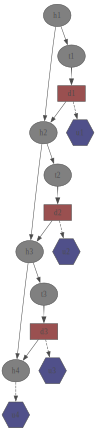

In [94]:
gnb.showInfluenceDiagram(id)

In [95]:
node1 = ClusterNode({id.variable('d1'), id.variable('u1'), id.variable('t1')}, {id.variable('h1'), id.variable('h2')})
node2 = ClusterNode({id.variable('d2'), id.variable('u2'), id.variable('t2')}, {id.variable('h2'), id.variable('h3')})
node3 = ClusterNode({id.variable('d3'), id.variable('u3'), id.variable('t3'), id.variable('h4'), id.variable('u4')}, {id.variable('h4')})

node1.children.append(node2)
node2.children.append(node3)
node3.parent = node2
node2.parent = node1
node3.isLeaf = True

In [96]:
ComputeTstMEU(node1)

1